## Align observations and Matching UV space of multi-instrument and multi configuration arrays observations.
In this notebook, you will find commom tasks to:
- shift visibilities into a commom phase centre
- compute matching uv space between different visibilities and generate new visibilities with only the matched region. 
### $\text{Work on NGC\, 5256}$

In [1]:
import casatools
import casatasks
import casaplotms
import casaviewer
from casaplotms import plotms
# import visread
# import uv_plot
# from uv_plot import *
from casatasks import listobs

In [2]:
msmd = casatools.msmetadata()
ms = casatools.ms()
tb = casatools.table()
# from visread import process, scatter, visualization

In [3]:
import astropy.io.fits as fits
import matplotlib.pyplot as plt
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
import numpy as np
from tqdm import tqdm
from astropy.stats import mad_std
from matplotlib.gridspec import GridSpec
from matplotlib import gridspec
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
import astropy.io.fits as pf

from astropy import coordinates
from astropy import units as u
from astropy.wcs import WCS
from astropy import visualization
from astropy.visualization import simple_norm
import astropy.visualization
import copy
from matplotlib.ticker import FuncFormatter, FormatStrFormatter
import glob

def reset_rc_params():
    mpl.rcParams.update({'font.size': 20, 
        'mathtext.fontset': 'stix',
        "text.usetex": False,
        "font.family": "sans-serif",
        "font.family": "sans",
        "font.serif": ["Exo 2"],
        "font.sans-serif": ["Exo 2"],
        'font.family': 'STIXGeneral', 
        'xtick.labelsize':20,
        'ytick.labelsize':20,
        'axes.labelsize' : 20,
        'xtick.major.width':1,
        'ytick.major.width':1,
        'axes.linewidth':1,
        'axes.edgecolor':'orange',
        'figure.figsize' : (6,6),
        'lines.linewidth':2,
        'legend.fontsize':20,
        "grid.linestyle":'--',                
        })
    pass
reset_rc_params()


In [4]:
def read_spws(vis):
    tb.open(vis + "/DATA_DESCRIPTION")
    SPECTRAL_WINDOW_ID = tb.getcol("SPECTRAL_WINDOW_ID")
    tb.close()
    # print(SPECTRAL_WINDOW_ID)
    return (SPECTRAL_WINDOW_ID)

def read_spws_v2(vis):
    spwtab = tb.open(vis+'::SPECTRAL_WINDOW')
    tb.close()
    return(spwtab)

def read_colsnames(vis):
    tb.open(vis)
    colnames = tb.colnames()
    tb.close()
    # print(colnames)
    return (colnames)


def query_ms(vis, spwid, query_args=['UVW', 'FLAG']):
    ms.open(vis)
    # select the key
    ms.selectinit(datadescid=spwid)
    query_results = ms.getdata(query_args)
    ms.selectinit(reset=True)
    ms.close()
    return (query_results)

def get_uvwave(vis, spw_id):
    from astropy.constants import c
    ms.open(vis)
    ms.selectinit(spw_id)
    d = ms.getdata(["uvw"])
    ms.done()
    msmd.open(vis)
    chan_freq = msmd.chanfreqs(spw_id)
    msmd.done()
    nchan = len(chan_freq)
    # print(nchan)
    # print(chan_freq)

    # d["uvw"] is an array of float64 with shape [3, nvis]
    u, v, w = d["uvw"]  # unpack into len nvis vectors
    broadcast = np.ones((nchan, 1))
    uu = u * broadcast
    vv = v * broadcast
    ww = w * broadcast

    wavelengths = c.value / chan_freq[:, np.newaxis]  # m
    uw = 1e-3 * uu / wavelengths  # [klambda]
    vw = 1e-3 * vv / wavelengths  # [klambda]
    return (uw, vw, wavelengths)

def get_blinfo():
    return dict([((x, y), np.where((ant1 == x) & (ant2 == y))[0]) 
                 for x in ant_uniq for y in ant_uniq if y > x])


def get_uvwave_tab(vis,index_freq=None):
    # spw info
    def get_blinfo():
        return dict([((x, y), np.where((ant1 == x) & (ant2 == y))[0]) 
                     for x in ant_uniq for y in ant_uniq if y > x])

    lightspeed = 299792458.0 # speed of light in m/s
    
    # spwtab = tb.open(vis+'::SPECTRAL_WINDOW')
    # chan_freq = tb.getcol('CHAN_FREQ').flatten()
    # tb.close()
    ms.open(vis)
    mydata = ms.getdata(['axis_info'])
    chan_freq = mydata['axis_info']['freq_axis']['chan_freq'].flatten()
    ms.close()

    #vis and antenna info
    tb.open(vis)
    uvw = tb.getcol('UVW')
    ant1 = tb.getcol('ANTENNA1')
    ant2 = tb.getcol('ANTENNA2')
    flag = tb.getcol('FLAG')
    flag_row = tb.getcol('FLAG_ROW')
    tb.close()
    tb.open(vis+'::ANTENNA')
    station = tb.getcol('STATION')
    tb.close()
    
    ant_uniq = np.unique(np.hstack((ant1, ant2)))
    bldict = get_blinfo()
    if index_freq is not None:
        wavelen = (lightspeed/chan_freq[index_freq])*1e3 # in Klambda
    else:
        wavelen = (lightspeed/chan_freq.mean())*1e3 # in Klambda
    # flag_final = np.logical_or(flag, flag_row[:,np.newaxis,np.newaxis])
    flag_final = np.logical_or(flag, flag_row[np.newaxis,np.newaxis,:])
    # flag_final_VLA = np.logical_or(flag_VLA, flag_row_VLA[:,np.newaxis,np.newaxis])
    # wavelen = (lightspeed/chan_freq.mean())*1e3
    uwave = uvw[0]/wavelen
    vwave = uvw[1]/wavelen
    uvwave = np.sqrt(uwave**2.0 + vwave**2.0)
    return(uvw,uvwave,wavelen)

def get_phase_centre(vis):
    from astropy.coordinates import SkyCoord
    import astropy.units as u

    msmd.open(vis)
    ra_radians = msmd.phasecenter()['m0']['value']
    dec_radians = msmd.phasecenter()['m1']['value']
    msmd.close()
    # Convert to SkyCoord object
    coord = SkyCoord(ra=ra_radians * u.radian, dec=dec_radians * u.radian, frame='icrs')

    # Format the output using 'hmsdms'
    formatted_coord = coord.to_string('hmsdms')
    formatted_ra, formatted_dec = formatted_coord.split()

    formatted_ra_hms = formatted_ra.replace('h', ':').replace('m', ':').replace('s', '')
    formatted_dec_dms = formatted_dec.replace('d', '.').replace('m', '.').replace('s', '')

    formatted_output = "J2000 {} {}".format(formatted_ra_hms, formatted_dec_dms)

    print(formatted_output)
    return (formatted_output)
    
    
def plot_uwave_vwave(vis,color='black',fig=None,ax=None,alpha=1.0,
                     chunk_size = int(8), #channel average
                     downsample_factor = 200
                    ):
    lightspeed = 299792458.0 # speed of light in m/s
    def get_blinfo():
        return dict([((x, y), np.where((ant1 == x) & (ant2 == y))[0]) 
                    for x in ant_uniq for y in ant_uniq if y > x])
    
#     spwtab = tb.open(vis+'::SPECTRAL_WINDOW')
#     chan_freq = tb.getcol('CHAN_FREQ').flatten()
#     tb.close()

    msmd.open(vis)
    bandwidth = msmd.bandwidths()
    nspw = len(bandwidth)
    chan_freqs_all = np.empty(nspw, dtype=object)
    spws_freq = np.zeros(nspw)

    for nch in range(nspw):
        chan_freqs_all[nch] = msmd.chanfreqs(nch)
        spws_freq[nch] = np.mean(chan_freqs_all[nch])
    msmd.done()
    chan_freq = np.concatenate(chan_freqs_all)
    
    #vis and antenna info
    tb.open(vis)
    uvw = tb.getcol('UVW')
    ant1 = tb.getcol('ANTENNA1')
    ant2 = tb.getcol('ANTENNA2')
    flag = tb.getcol('FLAG')
    flag_row = tb.getcol('FLAG_ROW')
    tb.close()
    tb.open(vis+'::ANTENNA')
    station = tb.getcol('STATION')
    tb.close()

    ant_uniq = np.unique(np.hstack((ant1, ant2)))
    bldict = get_blinfo()
    wavelen = (lightspeed/chan_freq.mean())*1e6 # in Klambda
    # flag_final = np.logical_or(flag, flag_row[:,np.newaxis,np.newaxis])
    flag_final = np.logical_or(flag, flag_row[np.newaxis,np.newaxis,:])
    # flag_final_VLA = np.logical_or(flag_VLA, flag_row_VLA[:,np.newaxis,np.newaxis])


    labels = {}
    for bl in bldict.keys():
        labels[bl] = station[bl[0]]+'-'+station[bl[1]]

    # plt.ion() 
    if fig is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    
    def chunk_average(arr, chunk_size):
        # Reshape the array to have chunks of size `chunk_size`
        reshaped = arr.reshape(arr.shape[0], -1, chunk_size)
        # Average over each chunk along the last axis
        return reshaped.mean(axis=2)
    
    def downsample(arr, factor):
        return arr[:, ::factor]
    
    chunk_size_plot = 1000
    
    
    
    reshaped_size = int(len(chan_freq)/chunk_size)
    avg_chan = chan_freq.reshape((reshaped_size, chunk_size))
    chunk_chan_mean = avg_chan.mean(axis=1)
    chunk_chan_mean_broad = np.repeat(chunk_chan_mean, chunk_size)
    chunk_chan_mean_column = chunk_chan_mean.reshape(-1, 1)
    UUU = []
    VVV = []
    for bl in tqdm(list(bldict.keys())[::1]):
        wavelen = (lightspeed/chunk_chan_mean_column)*1e3 # in Klambda
        u = uvw[0,bldict[bl]]
        v = uvw[1,bldict[bl]]
        uuu = np.tile(np.hstack([u, np.nan, -u]), (reshaped_size, 1))/wavelen
        # print(uuu.shape[0] *uuu.shape[1])
        vvv = np.tile(np.hstack([v, np.nan, -v]), (reshaped_size, 1))/wavelen
        # Reduce the datasets
        
        UUU_downsampled = downsample(uuu, downsample_factor)
        VVV_downsampled = downsample(vvv, downsample_factor)
        ax.plot(UUU_downsampled.T, VVV_downsampled.T, '.', markersize=0.5, color=color, alpha=0.7)
#         UUU_reduced = chunk_average(uuu, chunk_size_plot)
#         VVV_reduced = chunk_average(vvv, chunk_size_plot)
#         ax.plot(UUU_reduced.T, VVV_reduced.T, '.', markersize=0.5, color=color, alpha=0.7)
#         # ax.clear()  # Clear previous plot
#         ax.plot(uuu, vvv, '.',markersize=0.1,color=color,alpha=alpha)#, label=labels[bl])
#     #     fig.canvas.draw()
#     #     fig.canvas.flush_events()
#     # plt.ioff()
#     # plt.show()
    return(fig,ax)


def plot_uwave_vwave_v2(vis,color='black',fig=None,ax=None,alpha=1.0):
    lightspeed = 299792458.0 # speed of light in m/s
    def get_blinfo():
        return dict([((x, y), np.where((ant1 == x) & (ant2 == y))[0]) 
                    for x in ant_uniq for y in ant_uniq if y > x])
    spwtab = tb.open(vis+'::SPECTRAL_WINDOW')
    chan_freq = tb.getcol('CHAN_FREQ').flatten()
    tb.close()

    #vis and antenna info
    tb.open(vis)
    uvw = tb.getcol('UVW')
    ant1 = tb.getcol('ANTENNA1')
    ant2 = tb.getcol('ANTENNA2')
    flag = tb.getcol('FLAG')
    flag_row = tb.getcol('FLAG_ROW')
    tb.close()
    tb.open(vis+'::ANTENNA')
    station = tb.getcol('STATION')
    tb.close()

    ant_uniq = np.unique(np.hstack((ant1, ant2)))
    bldict = get_blinfo()
    wavelen = (lightspeed/chan_freq.mean())*1e6 # in Klambda
    # flag_final = np.logical_or(flag, flag_row[:,np.newaxis,np.newaxis])
    flag_final = np.logical_or(flag, flag_row[np.newaxis,np.newaxis,:])
    # flag_final_VLA = np.logical_or(flag_VLA, flag_row_VLA[:,np.newaxis,np.newaxis])


    labels = {}
    for bl in bldict.keys():
        labels[bl] = station[bl[0]]+'-'+station[bl[1]]

    # plt.ion() 
    if fig is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    
    def chunk_average(arr, chunk_size):
        # Reshape the array to have chunks of size `chunk_size`
        reshaped = arr.reshape(arr.shape[0], -1, chunk_size)
        # Average over each chunk along the last axis
        return reshaped.mean(axis=2)
    
    # Function to downsample an array along its columns (data points)
    def downsample(arr, factor):
        return arr[:, ::factor]

    # Function to average an array's rows (channels)
    def average_channels(arr, factor):
        # Reshape the array to have rows of size `factor`
        reshaped = arr.reshape(-1, factor, arr.shape[1])
        # Average over each set of rows
        return reshaped.mean(axis=1)
    
    # Downsampling and averaging factors
    downsample_factor = 1000  # For data points
    downsample_channel_factor = 64  # For channels
    
    chunk_size = int(12) #channel average
    reshaped_size = int(len(chan_freq)/chunk_size)
    avg_chan = chan_freq.reshape((reshaped_size, chunk_size))
    chunk_chan_mean = avg_chan.mean(axis=1)
    chunk_chan_mean_broad = np.repeat(chunk_chan_mean, chunk_size)
    chunk_chan_mean_column = chunk_chan_mean.reshape(-1, 1)
    UUU = []
    VVV = []
    for bl in tqdm(list(bldict.keys())[::1]):
        wavelen = (lightspeed/chunk_chan_mean_column)*1e3 # in Klambda
        u = uvw[0,bldict[bl]]
        v = uvw[1,bldict[bl]]
        uuu = np.tile(np.hstack([u, np.nan, -u]), (reshaped_size, 1))/wavelen
        # print(uuu.shape[0] *uuu.shape[1])
        vvv = np.tile(np.hstack([v, np.nan, -v]), (reshaped_size, 1))/wavelen
        # Reduce the datasets
        
        # Step 1: Downsample data points
        UUU_downsampled = downsample(uuu, downsample_factor)
        VVV_downsampled = downsample(vvv, downsample_factor)

        # Step 2: Average channels
        UUU_reduced = average_channels(UUU_downsampled, downsample_channel_factor)
        VVV_reduced = average_channels(VVV_downsampled, downsample_channel_factor)

        ax.plot(UUU_reduced.T, VVV_reduced.T, '.', markersize=0.5, color=color, alpha=0.7)
#         UUU_reduced = chunk_average(uuu, chunk_size_plot)
#         VVV_reduced = chunk_average(vvv, chunk_size_plot)
#         ax.plot(UUU_reduced.T, VVV_reduced.T, '.', markersize=0.5, color=color, alpha=0.7)
#         # ax.clear()  # Clear previous plot
#         ax.plot(uuu, vvv, '.',markersize=0.1,color=color,alpha=alpha)#, label=labels[bl])
#     #     fig.canvas.draw()
#     #     fig.canvas.flush_events()
#     # plt.ioff()
#     # plt.show()
    return(fig,ax)

## Create matched UV with VLA: (L,S,C,X){A} + (Ku,Ka){C}

### Set the path of all visibilities

In [5]:
# Lets set the path of all visibilities.
visibilities = [
    # '',
    '/mnt/ext10TB/LIRGI_Sample_done/VLA-Archive/A_config/23A-324/L_band/NGC5256/imaging_final/NGC5256_A_L_sf.ms',
    '/mnt/ext10TB/LIRGI_Sample_done/VLA-Archive/A_config/S_band/NGC5256/imaging_final/NGC5256_A_S_sf.ms',
    '/mnt/ext10TB/LIRGI_Sample_done/VLA-Archive/A_config/C_band/NGC5256/imaging_final/NGC5256_A_C_sf.ms',
    '/mnt/ext10TB/LIRGI_Sample_done/VLA-Archive/B_config/X_band/NGC5256/imaging_final/NGC5256_B_X_sf.ms',
    '/mnt/ext10TB/LIRGI_Sample_done/VLA-Archive/C_config/Ku_band/NGC5256/imaging_final/NGC5256_C_Ku_sf.ms',
    '/mnt/ext10TB/LIRGI_Sample_done/VLA-Archive/C_config/Ka_band/NGC5256/imaging_final/NGC5256_C_Ka_sf.ms',
        ]

# reference visibility (in our case, the e-MERLIN C band observation, that was self-calibrated with VLA-A C-band)
# We will use the phase centre of this visibility to shift all the other visibilities.
path_em = '/mnt/ext10TB/LIRGI_Sample_done/eMERLIN/LegacyArchive/C_band/NGC5256/imaging_final/'
name_em = 'NGC5256_eM_C_sfc'
vis_em = path_em + name_em + '.ms'
# So, in principle, VLA observations will be aligned with e-MERLIN. 
# Note that this should not be assumed as true. 
# Later during any analysis, additional checks should be made to know about any significant offsets.



In [6]:
def get_phase_centre_deg(vis):
    from astropy.coordinates import SkyCoord
    import astropy.units as u

    msmd.open(vis)
    ra_radians = msmd.phasecenter()['m0']['value']
    dec_radians = msmd.phasecenter()['m1']['value']
    msmd.close()
    # Convert to SkyCoord object
    coord = SkyCoord(ra=ra_radians * u.radian, dec=dec_radians * u.radian, frame='icrs')

    return(coord.ra.value,coord.dec.value)

def calculate_angular_distance(coord1, coord2):
    """
    Calculate the angular distance between two sky coordinates.

    Parameters:
    coord1: tuple of (RA1, Dec1) in degrees
    coord2: tuple of (RA2, Dec2) in degrees

    Returns:
    Angular distance in degrees
    """
    # Convert degrees to radians
    def deg_to_rad(deg):
        return deg * np.pi / 180

    # Extract coordinates
    ra1_deg, dec1_deg = coord1
    ra2_deg, dec2_deg = coord2

    # Convert to radians
    ra1 = deg_to_rad(ra1_deg)
    dec1 = deg_to_rad(dec1_deg)
    ra2 = deg_to_rad(ra2_deg)
    dec2 = deg_to_rad(dec2_deg)

    # Calculate the angular distance
    cos_angle = (np.sin(dec1) * np.sin(dec2) +
                 np.cos(dec1) * np.cos(dec2) * np.cos(ra1 - ra2))
    angular_distance_rad = np.arccos(cos_angle)

    # Convert to degrees
    # angular_distance_deg = angular_distance_rad * 180 / np.pi
    angular_distance_arcseconds = angular_distance_rad * (180 / np.pi) * 3600
    
    return angular_distance_arcseconds

In [7]:
# Print the phasecentre of each visibility.
ref_phasecentre = get_phase_centre(vis_em)
for vis in visibilities:
    _ = get_phase_centre(vis)

J2000 13:38:17.79 +48.16.41.2
J2000 13:38:17.49999943 +48.16.36.89999087
J2000 13:38:17.80000059 +48.16.41.09999611
J2000 13:38:17.79 +48.16.41.2
J2000 13:38:17.77000006 +48.16.41.09999611
J2000 13:38:17.49999943 +48.16.36.89999087
J2000 13:38:17.77000006 +48.16.41.09999611
J2000 13:38:17.80000059 +48.16.41.09999611
J2000 13:38:17.49999943 +48.16.36.89999087
J2000 13:38:17.80000059 +48.16.41.09999611
J2000 13:38:17.80000059 +48.16.41.09999611


We can see that some visibilities have different phase centre. We use now `phaseshift` to shift these observations to the common phase centre `ref_phasecentre`.

In [9]:
# Lets now run the phase shift.
ra_deg_ref,dec_deg_ref = get_phase_centre_deg(vis_em)

visibilities_shifted = []
k=0
for vis in tqdm(visibilities):
    shifted_vis = vis.replace('.ms','')+'_ps.ms'
    visibilities_shifted.append(shifted_vis)
    
    ra_deg_k,dec_deg_k = get_phase_centre_deg(visibilities[k])

    separation_arcsec = calculate_angular_distance((ra_deg_ref,dec_deg_ref), (ra_deg_k,dec_deg_k))
    print(f'Shift difference is {separation_arcsec} arcseconds')
    try:
        casatasks.phaseshift(vis=vis,phasecenter=ref_phasecentre,
               outputvis=shifted_vis)
    except Exception as e:
        print(f"No shift for vis {vis} due to {e}.")
    k=k+1

  0%|          | 0/10 [00:00<?, ?it/s]

Shift difference is 5.183752350471877 arcseconds


 10%|█         | 1/10 [01:33<13:58, 93.21s/it]

Shift difference is 0.14128465466791323 arcseconds


 20%|██        | 2/10 [03:16<13:14, 99.27s/it]

Shift difference is 0.0 arcseconds


 30%|███       | 3/10 [04:33<10:23, 89.07s/it]

Shift difference is 0.22329548348924844 arcseconds


 40%|████      | 4/10 [09:44<17:38, 176.50s/it]

Shift difference is 5.183752350471877 arcseconds


 50%|█████     | 5/10 [14:48<18:32, 222.49s/it]

Shift difference is 0.22329548348924844 arcseconds


 60%|██████    | 6/10 [16:18<11:50, 177.66s/it]

Shift difference is 0.14128465466791323 arcseconds


 70%|███████   | 7/10 [18:45<08:22, 167.54s/it]

Shift difference is 5.183752350471877 arcseconds


 80%|████████  | 8/10 [25:12<07:54, 237.29s/it]

Shift difference is 0.14128465466791323 arcseconds


 90%|█████████ | 9/10 [28:12<03:39, 219.58s/it]

Shift difference is 0.14128465466791323 arcseconds


100%|██████████| 10/10 [35:20<00:00, 212.09s/it]


In [10]:
visibilities_shifted

['/mnt/ext10TB/LIRGI_Sample_done/VLA-Archive/A_config/23A-324/L_band/NGC5256/imaging_final/NGC5256_A_L_sf_ps.ms',
 '/mnt/ext10TB/LIRGI_Sample_done/VLA-Archive/A_config/S_band/NGC5256/imaging_final/NGC5256_A_S_sf_ps.ms',
 '/mnt/ext10TB/LIRGI_Sample_done/eMERLIN/LegacyArchive/C_band/NGC5256/imaging_final/NGC5256_eM_C_sfc_ps.ms',
 '/mnt/ext10TB/LIRGI_Sample_done/VLA-Archive/A_config/C_band/NGC5256/imaging_final/NGC5256_A_C_sf_ps.ms',
 '/mnt/ext10TB/LIRGI_Sample_done/VLA-Archive/A_config/23A-324/X_band/NGC5256/imaging_final/NGC5256_A_X_sf_ps.ms',
 '/mnt/ext10TB/LIRGI_Sample_done/VLA-Archive/B_config/X_band/NGC5256/imaging_final/NGC5256_B_X_sf_ps.ms',
 '/mnt/ext10TB/LIRGI_Sample_done/VLA-Archive/A_config/Ku_band/NGC5256/imaging_final/NGC5256_A_Ku_sf_ps.ms',
 '/mnt/ext10TB/LIRGI_Sample_done/VLA-Archive/A_config/K_band/NGC5256/imaging_final/NGC5256_A_K_sf_ps.ms',
 '/mnt/ext10TB/LIRGI_Sample_done/VLA-Archive/C_config/Ku_band/NGC5256/imaging_final/NGC5256_C_Ku_sf_ps.ms',
 '/mnt/ext10TB/LIRGI_Sa

In [14]:
visibilities_shifted

['/mnt/ext10TB/LIRGI_Sample_done/VLA-Archive/A_config/23A-324/L_band/NGC5256/imaging_final/NGC5256_A_L_sf_ps.ms',
 '/mnt/ext10TB/LIRGI_Sample_done/VLA-Archive/A_config/S_band/NGC5256/imaging_final/NGC5256_A_S_sf_ps.ms',
 '/mnt/ext10TB/LIRGI_Sample_done/VLA-Archive/A_config/C_band/NGC5256/imaging_final/NGC5256_A_C_sf_ps.ms',
 '/mnt/ext10TB/LIRGI_Sample_done/VLA-Archive/B_config/X_band/NGC5256/imaging_final/NGC5256_B_X_sf_ps.ms',
 '/mnt/ext10TB/LIRGI_Sample_done/VLA-Archive/C_config/Ku_band/NGC5256/imaging_final/NGC5256_C_Ku_sf_ps.ms',
 '/mnt/ext10TB/LIRGI_Sample_done/VLA-Archive/C_config/Ka_band/NGC5256/imaging_final/NGC5256_C_Ka_sf_ps.ms']

In [15]:
spwids_visibilities = []
for vis in tqdm(visibilities_shifted):
    spwids = read_spws(vis=vis)
    spwids_visibilities.append(spwids)
    print(f"{spwids}")

100%|██████████| 6/6 [00:00<00:00, 92.41it/s]

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]


In [16]:
uvwave_data = []
for vis in tqdm(visibilities_shifted):
    _,uvwave_i,_ = get_uvwave_tab(vis,index_freq=0)#beggining of the band
    _,uvwave_f,_ = get_uvwave_tab(vis,index_freq=-1)# end of the band
    uvwave_data.append(np.concatenate((uvwave_i, uvwave_f)))

100%|██████████| 6/6 [02:35<00:00, 25.86s/it]


In [17]:
uvwave_data[1].shape

(1268800,)

In [18]:
# _uvwave_data = np.asarray(uvwave_data)

In [19]:
# Creating an object array
_uvwave_data = np.empty(len(uvwave_data), dtype=object)
_uvwave_data[:] = uvwave_data

print(_uvwave_data)

[array([ 71.51147072,  63.53993645,  43.86431842, ..., 134.51552366,
         90.80688318,  44.84341156])
 array([130.74242776,  68.36145614,  97.89491614, ..., 140.2698273 ,
         55.53131319, 102.96970877])
 array([125.56232594, 142.32992803, 322.83820003, ..., 282.11235496,
        125.85103193, 191.14077433])
 array([ 19.6672732 , 169.54246772,  57.9169676 , ..., 211.46805321,
        189.24277019,  22.65321253])
 array([136.3604683 ,  91.91045202, 103.63175092, ...,  45.25397495,
         20.78889695,  24.76773408])
 array([249.9576041 , 160.81201493, 183.11350762, ..., 101.04621815,
         46.41208927,  55.35147105])                                ]


In [20]:
_uvwave_data

array([array([ 71.51147072,  63.53993645,  43.86431842, ..., 134.51552366,
               90.80688318,  44.84341156])                                ,
       array([130.74242776,  68.36145614,  97.89491614, ..., 140.2698273 ,
               55.53131319, 102.96970877])                                ,
       array([125.56232594, 142.32992803, 322.83820003, ..., 282.11235496,
              125.85103193, 191.14077433])                                ,
       array([ 19.6672732 , 169.54246772,  57.9169676 , ..., 211.46805321,
              189.24277019,  22.65321253])                                ,
       array([136.3604683 ,  91.91045202, 103.63175092, ...,  45.25397495,
               20.78889695,  24.76773408])                                ,
       array([249.9576041 , 160.81201493, 183.11350762, ..., 101.04621815,
               46.41208927,  55.35147105])                                ],
      dtype=object)

In [21]:
# Step 1: Compute the min and max for each visibility's range
ranges = [(np.nanmin(arr), np.nanmax(arr)) for arr in uvwave_data]

# Step 2: Extract the min and max values into separate lists
min_values = [r[0] for r in ranges]
max_values = [r[1] for r in ranges]

# Step 3: Find the common range
common_min = np.nanmax(min_values)
common_max = np.nanmin(max_values)
# Step 4: Check if there is an actual common range
if common_min <= common_max:
    print(f"Common UVwave range: {common_min} to {common_max} klambda")
else:
    print("No common range found.")

Common UVwave range: 6.560889611803433 to 182.42991607041463 klambda


In [22]:
# uvwave_common_min = [np.nanmin(arr) for arr in uvwave_data]
# uvwave_common_max = [np.nanmax(arr) for arr in uvwave_data]
# common_max = np.nanmin(uvwave_common_max)
# common_min = np.nanmax(uvwave_common_min)


In [23]:
ranges

[(2.3563035727052126, 237.23580448522674),
 (4.6433227210440915, 461.8907947519845),
 (6.560889611803433, 945.0034830336022),
 (5.947240878066947, 417.4638463403305),
 (1.8901875008229225, 182.42991607041463),
 (3.7499991755961988, 354.3358456579075)]

# Split data with matching uvrange.

In [24]:
# Now, we have our common uvrange between all visibilities.
uvrange = f"{common_min:.2f}~{common_max:.2f} klambda"
print(uvrange)

6.56~182.43 klambda


In [25]:
# Therefore, we can split the original visibilities into new visibilities that contains uv points within the uvrange.
for vis in tqdm(visibilities_shifted):
    casatasks.split(vis=vis,keepflags=False,
                outputvis=vis.replace('.ms','_lowres.ms'),
                datacolumn='data',
                uvrange=uvrange)

100%|██████████| 6/6 [15:06<00:00, 151.14s/it]


In [ ]:
# We can now plot the new matched visibilities to inspect the matched uv plane. 
colors = ['purple','blue','green','red','grey','yellow','brown']
kk = 10
for i in tqdm(range(len(visibilities_shifted))):
    if i == 0:
        clearplots = True
    else:
        clearplots = False
    vis = visibilities_shifted[i]
    vis = visibilities_shifted[i]
    plotms(vis=vis.replace('.ms','_lowres.ms'),
       xaxis='uwave',yaxis='vwave',avgtime='36',avgchannel='6',
       customsymbol=True,symbolsize=1,plotindex=i, clearplots=clearplots,
       symbolcolor=colors[i], symbolshape='circle')

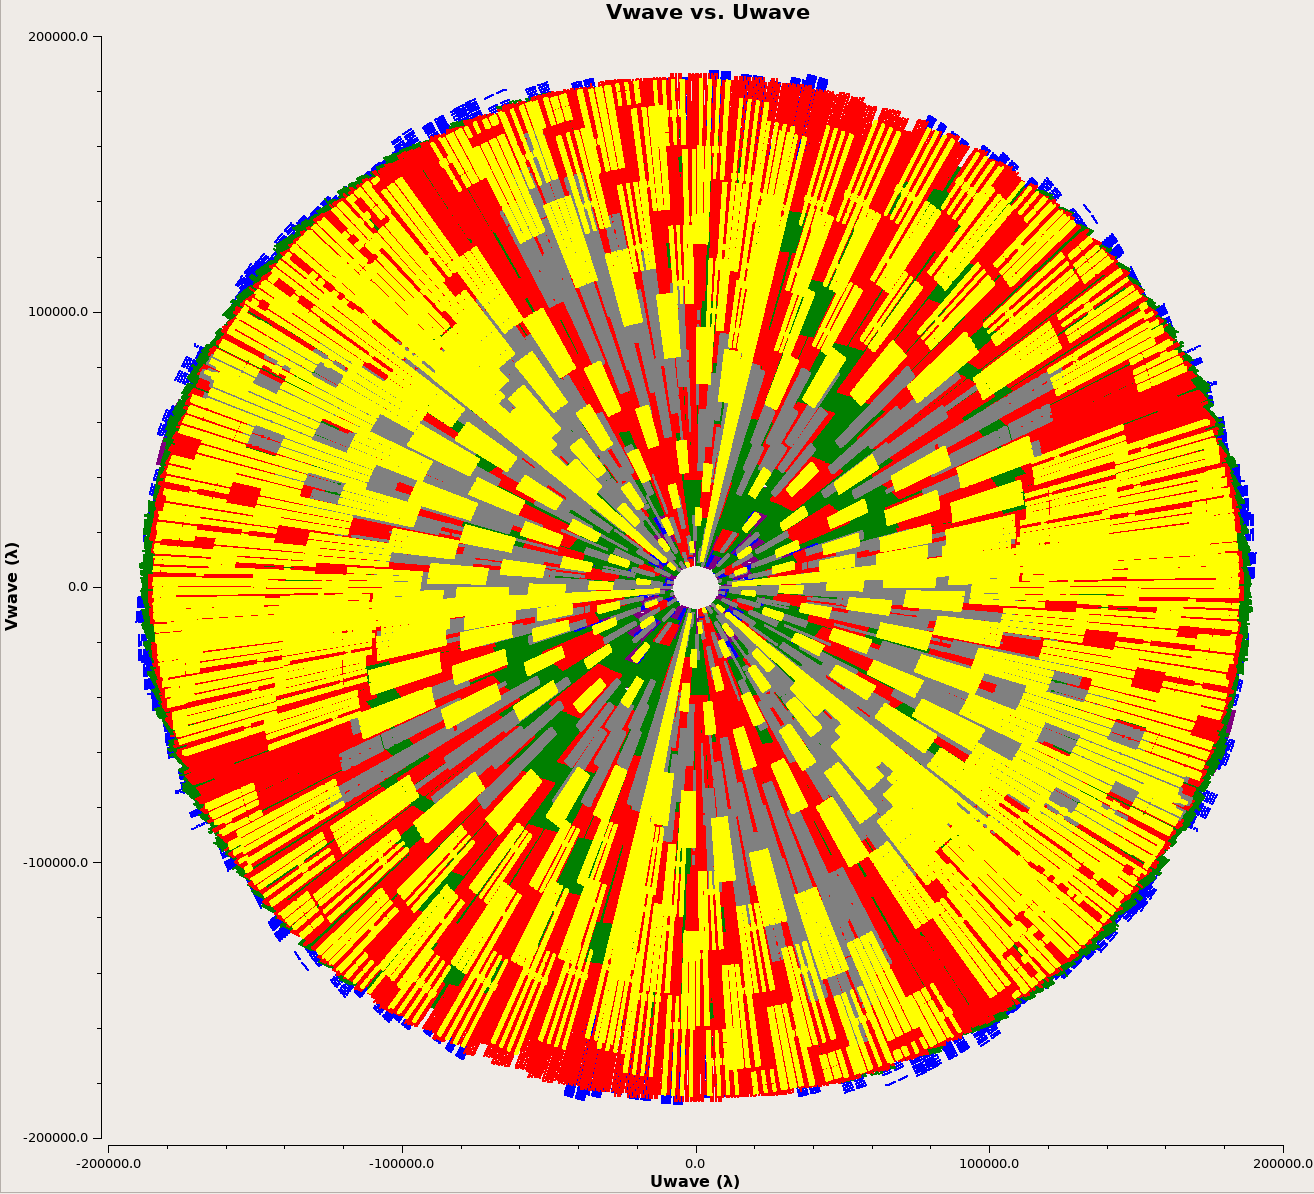